# Processing Sequences Using RNNs and CNNs

## Recurrent Neurons and Layers

### Memory Cells

### Input and Output Sequences

## Training RNNs

## Forecasting a Time Series

Suppose, we are studying the number of active users per hour on our website, or the daily temperature in city or company's financial health, measured quaterly using multiple metrics. In all these cases, the data will be sequence of one or more values per time step. This is called *time series*. In the first two examples there is single value per time step, so these are *univariate time series*, while in financial example there are mulitple values per step (e.g., company's debt, revenue, and so on), so it is a *multivariate time series*. A typical task is to predict future values, which is called *forecasting*. Another common task is to fill in the blanks: to predict (or rather "postdict") missing values from past. This is called `imputation`.

Let's get started:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

2024-03-03 21:46:23.680652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 21:46:23.809769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 21:46:23.810653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 21:46:25.056666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


For simplicity, we will use the time series generated by the `generate_time_series()` function:

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the `batch_size` argument), each of length `n_steps` length, and there is just one value per time step in each series (i.e., all series are univariate). The function returns a Numpy array of shape [*batch_size, time_steps, 1*], where each series is a sum of two sine waves of fixed amplitude but random frequencies and phases, plus a bit of noise.

**NOTE:**

When dealing with the time series (and other type of sequences such as sentences), the input features are generally represented as 3D arrays of shape [*batch_size, time_steps, dimensionality*], where *dimensionality* is 1 for univariate time series and more for multivariate time series.

Now let's create a training set, a validation set, and test set using this function:

In [3]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

`X_train` contains 7000 times series (i.e., its shape is [7000, 50, 1]), while `X_valid` contains 2000 and `X_test` contains 1000. Since we want to forecast a single value for each series, the target are column vectors (e.g., `y_train` has shape of [7000, 1])

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps+1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

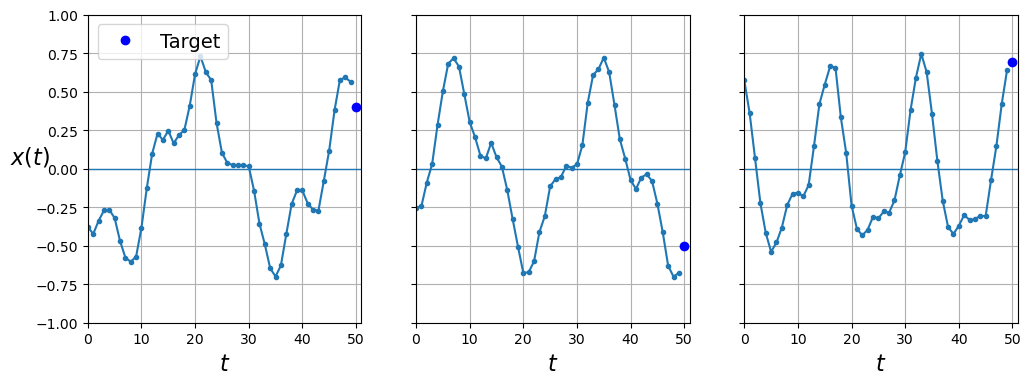

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col == 0 else None),
               legend=(col == 0))

plt.show()

### Baseline Metrics

Before we start using RNNs, it is often good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. 

For example, the simplest approach is to predict the last values in each series. This is called *naive forecasting*, and it is surprising difficult to outperform.

In [28]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In this case, it gives us a mean squared error of 0.020 .

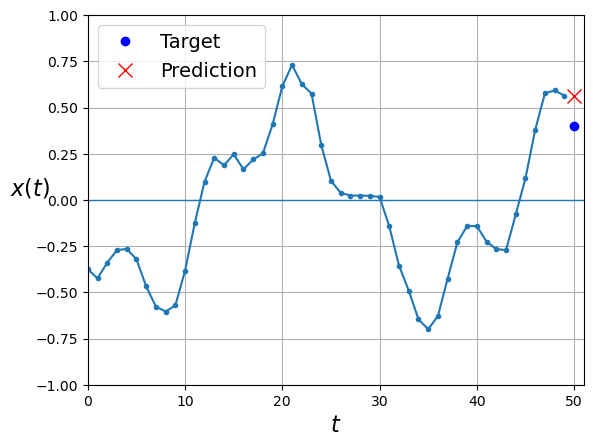

In [29]:
plot_series(X_valid[0, : ,0], y_valid[0,0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a `Flatten` layer. Let's just use a Simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
h = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.0942 - val_loss: 0.0430
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0228
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0186 - val_loss: 0.0159
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 7/20
219/219 [==============================] - 0s 999us/step - loss: 0.0084 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.00

In [33]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 731us/step - loss: 0.0038


0.003832163754850626

We got an MSE of about 0.004. That's much better than naive approach!

In [34]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    # plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

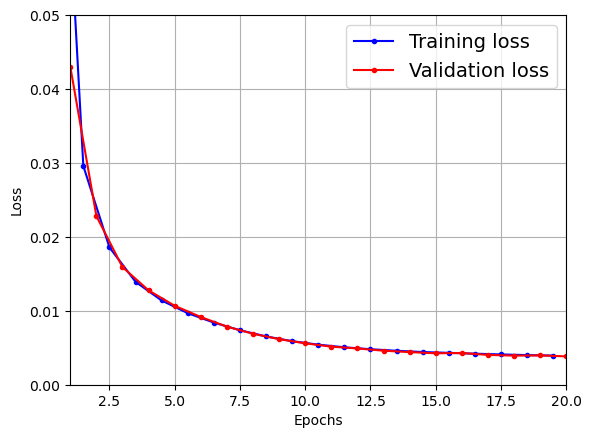

In [35]:
plot_learning_curves(h.history["loss"], h.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 683us/step


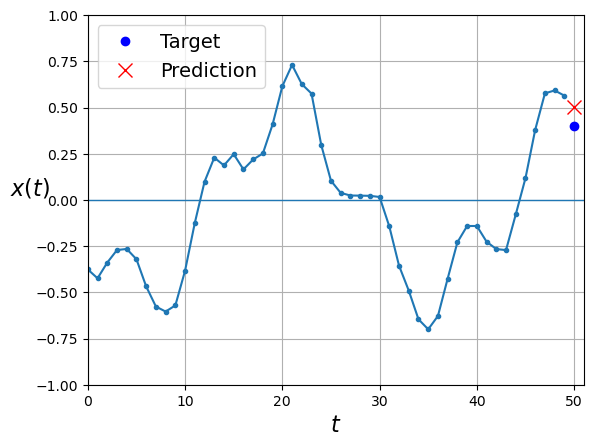

In [37]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Implementing Simple RNN

Let's see if we can beat that with simple RNN:

In [38]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

That's really the simplest RNN we can build. It just contains a single layer, with a single neuron. We do not need to specify the length of the input sequences since RNNs can process any number of steps. 

By default, the `SimpleRNN` layer uses the `tanh` activation function.

It works exactly the same way as we saw earlier: the initial state $h_{(init)}$ is set to 0, and it is passed to to a single recurrent neuron, along with the values of the first time step, $x_{(0)}$. The neuron computes a weighted sum of these values and applies the *tanh* activation function to the result, and this gives the first output $y_0$. In a simple RNN, this output is also the new state $h_{(0)}$. This new state is passed to the same recurrent neuron along with the next input value, $x_{(1)}$, and the process is repeated until last step. Then the layer just outputs the last value , $y_{49}$. All of this is performed simultaneously for every time series. 

**NOTE:**

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, we must set `return_sequences=True`

In [39]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
h = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.3325 - val_loss: 0.1802
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1527 - val_loss: 0.1499
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1465 - val_loss: 0.1594
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1456 - val_loss: 0.1486
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1478 - val_loss: 0.1529
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1142 - val_loss: 0.0691
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0496 - val_loss: 0.0401
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0337 - val_loss: 0.0299
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0267 - val_loss: 0.0244
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0225 - val_loss: 0.0209

In [40]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0111


0.011078794486820698

We got MSE of 0.011, so it is better than naive approach but it does not beat simple linear regression. 

Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in simple linear model, that's total of 51 parameters). In contrast, for each recurrent neuron in simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that's just the number of recurrent neurons in the layer), plus a bias term. In simple RNN, that's just a total of just three parameters.

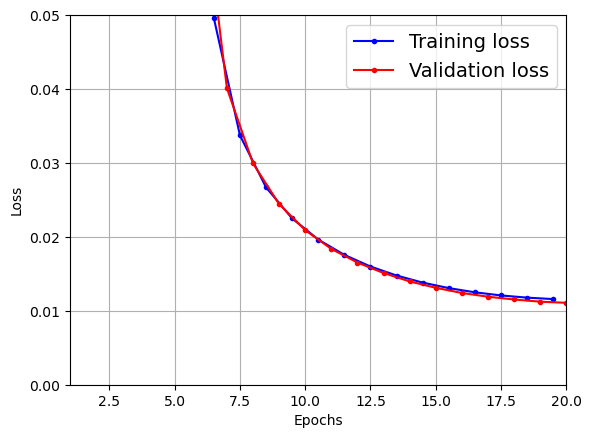

In [41]:
plot_learning_curves(h.history["loss"], h.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 2ms/step


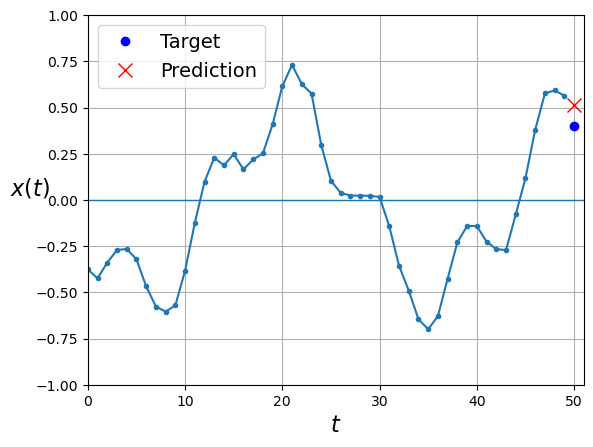

In [42]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()

Apparently our simple RNN was too simple to get good performance. So let's try to add more recurrent layers!

### Deep RNNs

In [44]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

**Warning:**

Make sure to set the `return_sequences=True` for all the recurrent layers (except the last one, if we only care about the last output). If we don't, they will output a 2D array (containing only the output of last time step) instead of 3D array (containing output of all time steps), and the next recurrent layer will complain that we are not feeding it sequences in the expected 3D format.

In [45]:
model.compile(loss="mse", optimizer="adam")
h = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 16ms/step - loss: 0.0293 - val_loss: 0.0060
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0029 - val_lo

In [46]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0027


0.00271416362375021

We got MSE of 0.0027. We finally managed to beat the linear model!

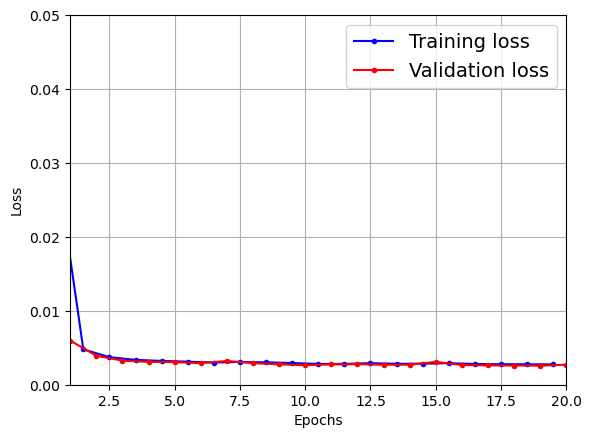

In [47]:
plot_learning_curves(h.history["loss"], h.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 4ms/step


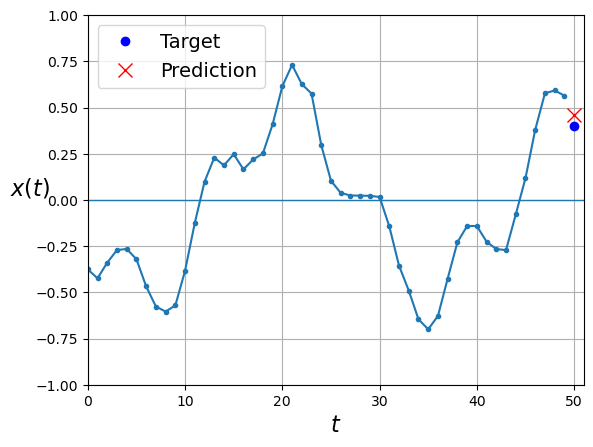

In [48]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0,0])
plt.show()

Note that the last layer we used in Deep RNN is not ideal: it must have a single unit because we want to forcast a univariate time series, and this means we have a single output value per time step. However, having a single unit means that the hidden state is just a single number. That's really not much, and it's probably not that useful; presumably, the RNN will mostly use hidden state of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer's hidden state very much. 

Moreover, since a `SimpleRNN` layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. But what if you want to use another activation function? For
both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly
the same, and it would allow us to choose any output activation function
we want. If you make this change, also make sure to remove
`return_sequences=True` from the second (now last) recurrent layer:

If we train this model, we will see that it converges faster and performs just as well.

In [49]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
h = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.0583 - val_loss: 0.0092
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0031 - val_lo

In [50]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0027


0.002655226504430175

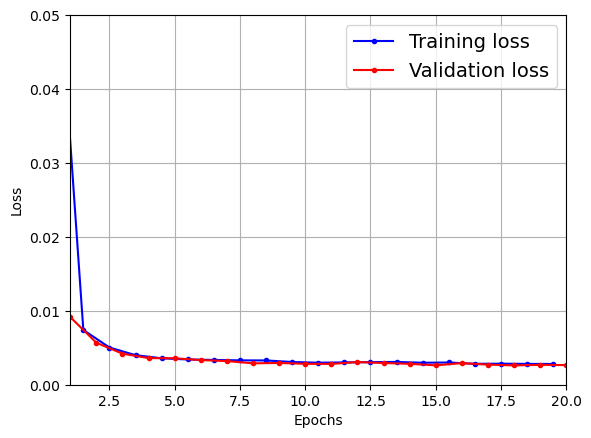

In [51]:
plot_learning_curves(h.history["loss"], h.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 3ms/step


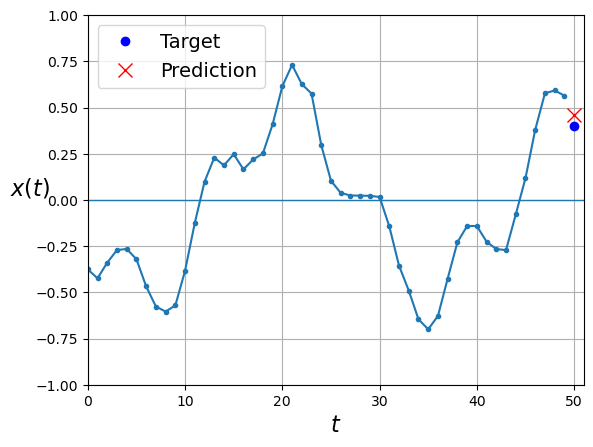

In [52]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0,0])
plt.show()

### Forecasting Several Time Steps Ahead

So far we have only predicted the value at the next time step, but we could easily have predicted the values several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to the value 10 steps ahead instead of 1 step ahead). But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had already occured), and use the the model again to predict the following value, and so on, as shown following:

In [53]:
np.random.seed(43)

series = generate_time_series(1, n_steps+10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
    
Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 16ms/step


In [54]:
Y_pred.shape

(1, 10, 1)

In [8]:
def plot_multiple_forecast(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, : , 0])
    plt.plot(np.arange(n_steps, n_steps+ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps+ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps+ahead, -1, 1])
    plt.legend(fontsize=14)

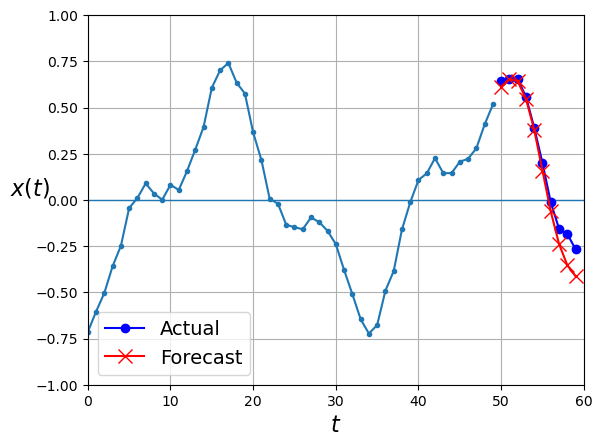

In [56]:
plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

As we might expect, the prediction for the next step will be usually more accurate than predictions for later time steps, since the errors might accumulate (as we can see above).

The second option is to train RNN to predict all 10 next values at once. We can still use sequence-to-vector model, but it will output 10 values instead of 1:

In [5]:
series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000: , :n_steps], series[9000:, -10:, 0]

Now we just need the output layer to have 10 units instead of 1:

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
h = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 14ms/step - loss: 0.0636 - val_loss: 0.0311
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0250 - val_loss: 0.0192
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0180 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0098 - val_lo

Now we can predict the next 10 values at once very easily:

In [7]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 244ms/step


In [11]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0078


0.007814709097146988

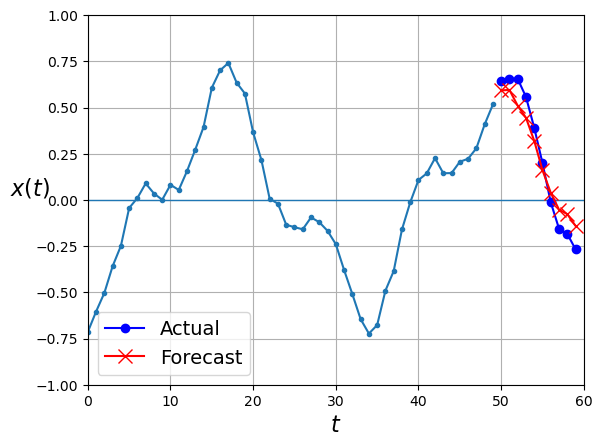

In [9]:
plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

This model works nicely: the MSE for the next 10 time steps is about 0.008. That's much better than linear model. But we can still do better: indeed, instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at last time step. This means there will be more error gradients flowing through the model, and they won't have to flow only through time; they will also flow from output of each time step. This will both stabilize and speed up training.

To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 10, then at time step 1 the model will forecast time steps 2 to 11, and so on. So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Let's prepare target sequences:

In [30]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
Y_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D 

for step_ahead in range(1, 10+1):
    Y[:, :, step_ahead-1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [31]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

**NOTE:**

It might be surprising that the targets will contain the values that appear in the inputs (there is lot of overlap between `X_train` and `Y_train`). Isn't that cheating. Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be *casual* model.

To turn the model sequence-to-sequence we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step. Keras offers a `TimeDistributed` layer for this purpose: it wraps any layer (e.g., a Dense Layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a seperate instance (i.e., it reshapes the inputs from [*batch_size, time_steps, input_dimensions*] to [*batch_size x time_steps, input_dimenstions*]; in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units), then it runs a Dense layer, and finally reshapes the output back to sequences.

Here's updated model:

In [32]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # TimeDistributed(Dense(n)) layer is equivalent to Conv1D(n, filter_size=1)
])

All the outputs are needed during training, but only the last output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all the outputs for training, we will use custom metric for evaluation, to compute the MSE over all the outputs at the last time step:

In [33]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
h = model.fit(X_train, Y_train , epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 15ms/step - loss: 0.0486 - last_time_step_mse: 0.0365 - val_loss: 0.2501 - val_last_time_step_mse: 0.2530
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0354 - last_time_step_mse: 0.0230 - val_loss: 0.2625 - val_last_time_step_mse: 0.2694
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0314 - last_time_step_mse: 0.0193 - val_loss: 0.2528 - val_last_time_step_mse: 0.2624
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0289 - last_time_step_mse: 0.0168 - val_loss: 0.2680 - val_last_time_step_mse: 0.2799
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0255 - last_time_step_mse: 0.0128 - val_loss: 0.2712 - val_last_time_step_mse: 0.2856
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0235 - last_time_step_mse: 0.0108 - val_loss: 0.2719 - val_last_time_step_mse: 0.2878
Epoch 7/20
219/219 [==

We got an validation MSE of 0.006, which is 25% better than previous model.

In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 224ms/step


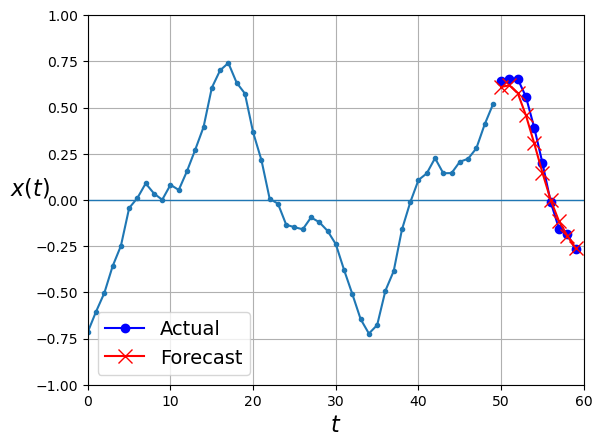

In [37]:
plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

## Handling Long Sequences

### Fighting Unstable Gradient Problem

Let's use tf.keras to implement Layer Normalization within a simple memory cell. For this we need to define a custom memory cell. It is just like a regular layer, except its `call()` method takes two arguments: the `inputs` at the current time step and the hidden `states` from previous time step. `states` argument is a list containing one or more tensors. In case of simple RNN cell, it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors. A cell must have a `state_size` and `output_size` attribute. In simple RNN, both are equal to the number of units. The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each step:

In [38]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Our `LNSimpleRNNCell` class inherits from the `keras.layers.Layer` class, just like any custom layer. The constructor takes the number of units and the desired activation function, and it sets the `state_size` and `output_size` attributes, then creates a `SimpleRNNCell` with no activation function (because we want to perform the Layer Normalization after the linear operation but before the activation function). The constructor then creates the `LayerNormalization` layer, and finally it fetches the desired activation function. 

The `call()` method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a `SimpleRNNCell`, the outputs are just equal to the hidden states: in other words, `new_states[0]` is equal to `outputs`, so we can safely ignore `new_states` in the rest of the `call` method). Next, the `call()` method applies Layer Normalization, followed by the activation function. Finally it returns the output twice (once as the outputs, and once as the new hidden states). 

To use this custom cell, all we need is to create a `keras.layers.RNN` layer, passing it a cell instance:

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
h = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 21ms/step - loss: 0.1580 - last_time_step_mse: 0.1397 - val_loss: 0.2292 - val_last_time_step_mse: 0.2214
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0601 - last_time_step_mse: 0.0479 - val_loss: 0.2415 - val_last_time_step_mse: 0.2367
Epoch 3/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0500 - last_time_step_mse: 0.0361 - val_loss: 0.2463 - val_last_time_step_mse: 0.2443
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0449 - last_time_step_mse: 0.0306 - val_loss: 0.2473 - val_last_time_step_mse: 0.2494
Epoch 5/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0417 - last_time_step_mse: 0.0266 - val_loss: 0.2561 - val_last_time_step_mse: 0.2638
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0388 - last_time_step_mse: 0.0239 - val_loss: 0.2556 - val_last_time_step_mse: 0.2677
Epoch 7/20
219/219 [==

Similarly, we could create a custom cell to apply dropout between each time step. But there's a simpler way: all recurrent layers (except for `keras.layers.RNN`) and all cells provided by Keras have a `dropout` hyperparameter and a `recurrent_dropout` hyperparameter: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step). No need to crate a custom cell to apply dropout at each time step in an RNN.

### Tackling Short Term Memory Problem

#### LSTM Cell

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

Alternatively, we could use the general-purpose `keras.layers.RNN` layer, giving it an `LSTMCell` as an argument:

In [3]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

However, `LSTM` layer uses an optimized implementation when running on GPU, so it is generally preferable to use it (the `RNN` layer is mostly useful when we define custom cells).

#### Peephole Connections